Python code to visualize results from Mie theory fits of experimental data

In [11]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.simulators import UVVisExperiment
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [12]:
ITERATION = 14
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(ITERATION)
expt.generate(use_spline=True)

Loading data from iteration 0 with shapes: (12, 2) (12, 101)
Loading data from iteration 1 with shapes: (6, 2) (6, 101)
Loading data from iteration 2 with shapes: (6, 2) (6, 101)
Loading data from iteration 3 with shapes: (6, 2) (6, 101)
Loading data from iteration 4 with shapes: (6, 2) (6, 101)
Loading data from iteration 5 with shapes: (6, 2) (6, 101)
Loading data from iteration 6 with shapes: (6, 2) (6, 101)
Loading data from iteration 7 with shapes: (6, 2) (6, 101)
Loading data from iteration 8 with shapes: (6, 2) (6, 101)
Loading data from iteration 9 with shapes: (6, 2) (6, 101)
Loading data from iteration 10 with shapes: (6, 2) (6, 101)
Loading data from iteration 11 with shapes: (6, 2) (6, 101)
Loading data from iteration 12 with shapes: (6, 2) (6, 101)
Loading data from iteration 13 with shapes: (6, 2) (6, 101)


In [26]:
fitted_params = np.ones((expt.comps.shape[0], 5))
param_names =  ["label", 
                "ar_mu", "ar_sig", "em_rod", # nanorod parameters
                "w" # mixed sphere and nanorod model weight
                ]
for i in range(expt.comps.shape[0]):
    try:
        result = np.load("./data/mie/res_%d.npz"%i)
        feats = result["feats"]
    except FileNotFoundError:
        feats = 0
    if feats==2:
        fitted_params[i, 0] = 2
        fitted_params[i, 1:] = result["best_X"][3:]

In [27]:
def prettify_axis(ax):
    ax.set_xlabel(r"Silver Nitrate ($10^{-4}$ M)")
    ax.set_ylabel(r"Ascorbic Acid ($10^{-3}$ M)")
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

    SN_labels = [item.get_text() for item in ax.get_xticklabels()]
    SN_vol_to_conc = lambda v : (6.4*v)/(300)
    SN_conc_labels = []
    for l in SN_labels:
        SN_conc_labels.append("%.2f"%SN_vol_to_conc(float(l)))
    ax.set_xticklabels(SN_conc_labels)

    AA_labels = [item.get_text() for item in ax.get_yticklabels()]
    AA_vol_to_conc = lambda v : (6.3*v)/(300)
    AA_conc_labels = []
    for l in AA_labels:
        AA_conc_labels.append("%.2f"%AA_vol_to_conc(float(l)))
    ax.set_yticklabels(AA_conc_labels)

    return ax

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3905/951585302.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3905/951585302.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3905/951585302.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3905/951585302.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


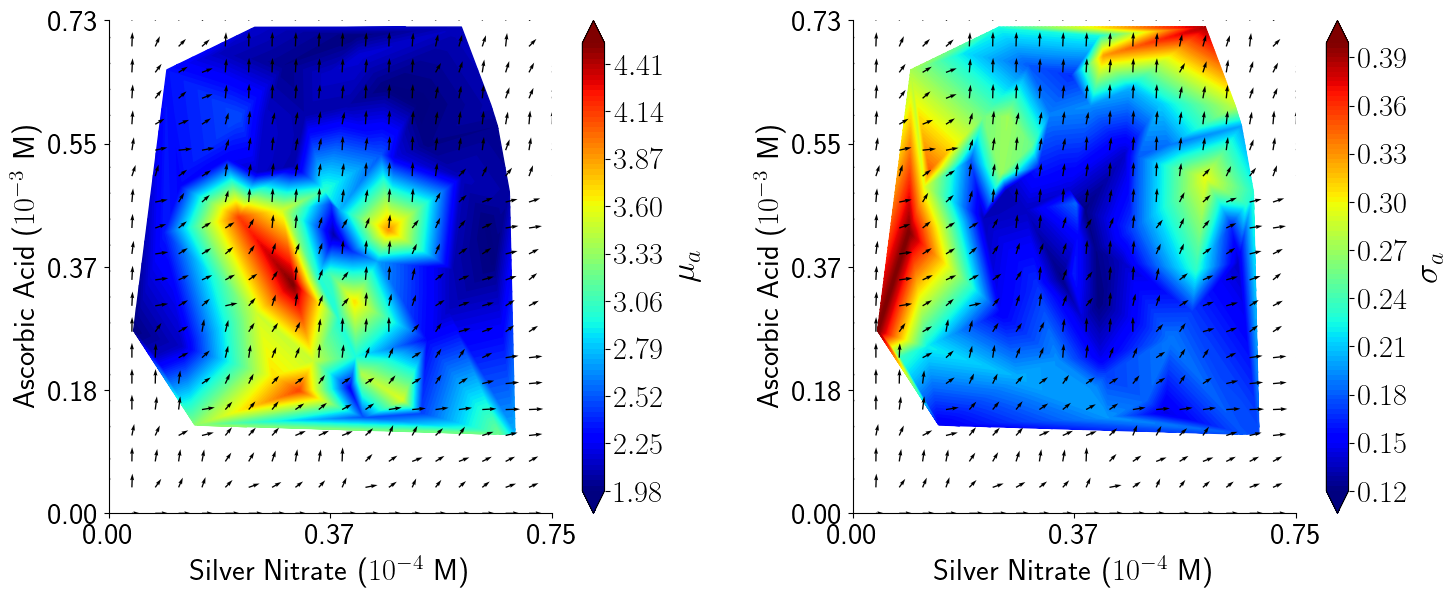

In [30]:
gradient_data = np.load("./data/gradient_data.npz")

grid_grad = gradient_data["grid_grad"]
grid_norm = gradient_data["grid_norm"]
grid_data = np.load("./data/grid_data_20.npz")
grid_comps = grid_data["comps"]
U = grid_grad[:,0]
V = grid_grad[:,1]
# Normalize the arrows:
U = U / (grid_norm+1e-3) 
V = V / (grid_norm+1e-3)
with plt.style.context(pyplot_style):
        fig, axs = plt.subplots(1,2, figsize=(2*8, 0.8*8))
        fig.subplots_adjust(wspace=0.5)
        flags = fitted_params[:,0]==2
        param_indices = [1, 2]
        param_names = ["$\mu_{a}$", "$\sigma_{a}$"]
        for i, param_id in enumerate(param_indices):
                param_values = fitted_params[flags, param_id]
                mappable = axs[i].tricontourf(expt.comps[flags,0], 
                                expt.comps[flags,1],
                                param_values,
                                levels=100,
                                extend='both',
                                alpha=1.0,
                                antialiased=True,
                                cmap="jet"
                        )
                mappable.set_edgecolor("face")
                divider = make_axes_locatable(axs[i])
                cax = divider.append_axes('right', size='5%', pad=0.3)
                cbar = fig.colorbar(mappable, cax=cax)
                cbar.ax.set_ylabel(param_names[i], rotation=90, fontsize=25)
                axs[i].quiver(grid_comps[:,0], 
                        grid_comps[:,1], 
                        U, 
                        V, 
                        color="k",
                        units='width'
                        )
                prettify_axis(axs[i])
        plt.show()
